## Patient data

### Machine learning

In [63]:
input_file = "D:/TCGA alighned/Celligner_aligned_data.csv" #Big file, so read line by line
#Download from https://figshare.com/articles/dataset/Celligner_data/11965269/4

output_file = "../data/Depmap_aligned.csv" #Smaller file with only DepMap samples
n = 0
with open(input_file, "r", encoding="utf-8") as infile, \
     open(output_file, "w", encoding="utf-8") as outfile:
    header = infile.readline()
    outfile.write(header)
    for line in infile:
        if line.startswith("\"ACH-"):
            outfile.write(line)
            n += 1
print(f"Extracted {n} lines to {output_file}")


Extracted 1249 lines to ../data/Depmap_aligned.csv


In [64]:
import pandas as pd
df_exp = pd.read_csv("../data/Depmap_aligned.csv",index_col=0) 

In [2]:
cluster = pd.read_csv("../cluster_hippo.csv",index_col=0)
clusterdic = {id: cluster.loc[id,"Cluster"] for id in cluster.index}

In [68]:
from sklearn.preprocessing import StandardScaler
df_exp_dep = df_exp[[d in clusterdic for d in df_exp.index]].dropna(axis=1,how="any").copy()
df_exp_dep = df_exp_dep.loc[:, df_exp_dep.std() != 0]
normalized = StandardScaler().fit_transform(df_exp_dep)
df_exp_dep = pd.DataFrame(normalized, index=df_exp_dep.index, columns=df_exp_dep.columns)

X = df_exp_dep.values
y = [clusterdic[d] for d in df_exp_dep.index]

In [ ]:

#Fig. S8b, S8c
#Cross Validation with multiple random seeds and baseline
import pandas as pd
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score, confusion_matrix
import numpy as np
import warnings

models = {
    "LogisticRegression0001": LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, C=0.001),
    "LogisticRegression001": LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, C=0.01),
    "LogisticRegression01": LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, C=0.1),
    "LogisticRegression1": LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, C=1),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
}
results = []
for seed in range(5):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            for name, model in models.items():
                print(f"Random Seed: {seed},   Model: {name}")
                pipeline = Pipeline([('smote', SMOTE(random_state=seed)), ('model', model)])
                y_proba = cross_val_predict(pipeline, X, y, cv=cv, method='predict_proba')
                for threshold in [0.1,0.2,0.3,0.5]:
                    y_pred = [4 if proba[4]>threshold else np.argmax(proba) for proba in y_proba]
                    results.append({
                    "Method": name,
                    "Seed": seed,
                    "Threshold": threshold,
                    "Accuracy": accuracy_score(y, y_pred),
                        "Macro F1": f1_score(y, y_pred, average='macro'),
                        "Weighted F1": f1_score(y, y_pred, average='weighted'),
                        "Balanced Acc": balanced_accuracy_score(y, y_pred)
                    })

# Baseline: Random
for seed in range(5):
    np.random.seed(seed)
    y_unique = np.unique(y)
    y_pred_random = np.random.choice(y_unique, size=len(y))
    results.append({
        "Method": "Random Baseline",
        "Seed": seed,
        'Threshold': 'N/A',
        "Accuracy": accuracy_score(y, y_pred_random),
        "Macro F1": f1_score(y, y_pred_random, average='macro'),
        "Weighted F1": f1_score(y, y_pred_random, average='weighted'),
        "Balanced Acc": balanced_accuracy_score(y, y_pred_random)
    })

df_results = pd.DataFrame(results)
df_results.to_csv('../result/ML_compare.csv', index=False)

Random Seed: 0,   Model: LogisticRegression0001
Random Seed: 0,   Model: LogisticRegression001
Random Seed: 0,   Model: LogisticRegression01
Random Seed: 0,   Model: LogisticRegression1
Random Seed: 0,   Model: RandomForest
Random Seed: 0,   Model: XGBoost
Random Seed: 1,   Model: LogisticRegression0001
Random Seed: 1,   Model: LogisticRegression001
Random Seed: 1,   Model: LogisticRegression01
Random Seed: 1,   Model: LogisticRegression1
Random Seed: 1,   Model: RandomForest
Random Seed: 1,   Model: XGBoost
Random Seed: 2,   Model: LogisticRegression0001
Random Seed: 2,   Model: LogisticRegression001
Random Seed: 2,   Model: LogisticRegression01
Random Seed: 2,   Model: LogisticRegression1
Random Seed: 2,   Model: RandomForest
Random Seed: 2,   Model: XGBoost
Random Seed: 3,   Model: LogisticRegression0001
Random Seed: 3,   Model: LogisticRegression001
Random Seed: 3,   Model: LogisticRegression01
Random Seed: 3,   Model: LogisticRegression1
Random Seed: 3,   Model: RandomForest
Rando

In [34]:
df_results.groupby(by=["Method","Threshold"]).mean().reset_index().sort_values('Macro F1',ascending=False)
df_results.to_csv('../result/ML_compare.csv', index=False)

In [45]:
df_results.groupby(by=["Method","Threshold"]).mean().reset_index().sort_values('Balanced Acc',ascending=False)


,Method,Threshold,Seed,Accuracy,Macro F1,Weighted F1,Balanced Acc
21,XGBoost,0.1,2.0,0.571362,0.592415,0.566457,0.626111
22,XGBoost,0.2,2.0,0.582394,0.601905,0.578418,0.621193
23,XGBoost,0.3,2.0,0.589671,0.607186,0.586145,0.618884
24,XGBoost,0.5,2.0,0.588967,0.601492,0.585043,0.606628
18,RandomForest,0.2,2.0,0.521831,0.546178,0.509946,0.599234
19,RandomForest,0.3,2.0,0.552817,0.575497,0.547801,0.594593
1,LogisticRegression0001,0.2,2.0,0.540845,0.566094,0.539095,0.592780
0,LogisticRegression0001,0.1,2.0,0.514319,0.540892,0.509028,0.589721
2,LogisticRegression0001,0.3,2.0,0.549531,0.571206,0.549225,0.583322
4,LogisticRegression001,0.1,2.0,0.527700,0.553951,0.526919,0.582792


<Axes: >

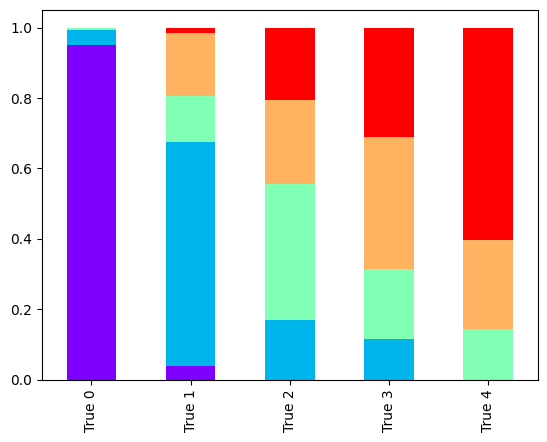

In [69]:
#Fig. S8d
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score, confusion_matrix, classification_report
import numpy as np
import pandas as pd

pipeline = Pipeline([
    ('smote', SMOTE()), 
    ('logistic', LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, C=0.001))
])

cv = StratifiedKFold(n_splits=5)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    y_proba = cross_val_predict(pipeline, X, y, cv=cv, method='predict_proba')
y_pred = [4 if proba[4] > 0.2 else np.argmax(proba) for proba in y_proba]

accuracy = accuracy_score(y, y_pred)
macro_f1 = f1_score(y, y_pred, average='macro')
weighted_f1 = f1_score(y, y_pred, average='weighted')
balanced_acc = balanced_accuracy_score(y, y_pred)

conf_matrix = confusion_matrix(y, y_pred, labels=[0, 1, 2, 3, 4])
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
df = pd.DataFrame(conf_matrix_normalized, columns=[f'Pred {i}' for i in range(5)], index=[f'True {i}' for i in range(5)])
df.plot(kind='bar', stacked=True,  colormap="rainbow",legend=False)

In [ ]:
import pickle
pickle.dump(pipeline, open("../model/logistic_regression_model.pkl", "wb"))

In [71]:
#ML for large TCGA data
import pandas as pd
import numpy as np
from tqdm import tqdm

def custom_predict(clf, X):
    y_proba = clf.predict_proba(X)  # 予測確率を取得
    y_pred = [4 if proba[4] > 0.2 else np.argmax(proba) for proba in y_proba]
    return np.array(y_pred)

pipeline = Pipeline([
    ('smote', SMOTE()), 
    ('logistic', LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, C=0.001))
])
pipeline.fit(X, y)
print("Model trained.")


c:\Users\ki949\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\ki949\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Model trained.


In [74]:
# Predict on large TCGA data in chunks
file_path = 'D:/TCGA alighned/Celligner_aligned_data.csv'
#Download from https://figshare.com/articles/dataset/Celligner_data/11965269/4

results = []
relevant_cols = [d for d in df_exp_dep.columns]
for chunk in tqdm(pd.read_csv(file_path, index_col=0, chunksize=100, iterator=True)):
    if relevant_cols:
        X_chunk = chunk[relevant_cols].values
        y_pred = custom_predict(pipeline, X_chunk)
        results.extend(zip(chunk.index, y_pred))

results_df = pd.DataFrame(results, columns=['Index', 'Prediction'])

0it [00:00, ?it/s]

135it [04:06,  1.82s/it]


In [75]:
results_df

,Index,Prediction
0,TH27_1241_S01,2
1,TARGET-40-0A4I65-01A-01R,4
2,THR24_1965_S01,3
3,THR24_2080_S01,4
4,THR20_0494_S01,2
...,...,...
13480,ACH-000904,2
13481,ACH-000110,3
13482,ACH-000261,4
13483,ACH-000031,4


<Axes: >

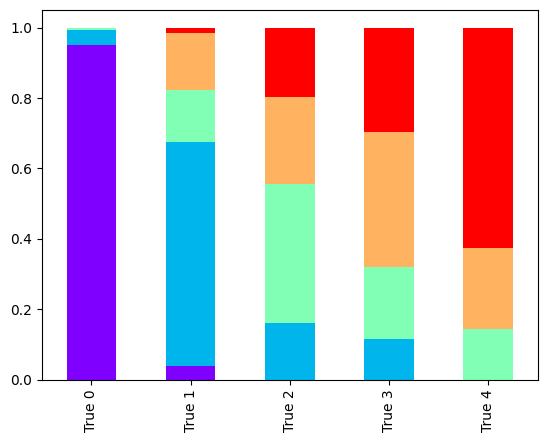

In [46]:

y_pred = [4 if proba[4] > 0.2 else np.argmax(proba) for proba in y_proba]

accuracy = accuracy_score(y, y_pred)
macro_f1 = f1_score(y, y_pred, average='macro')
weighted_f1 = f1_score(y, y_pred, average='weighted')
balanced_acc = balanced_accuracy_score(y, y_pred)

conf_matrix = confusion_matrix(y, y_pred, labels=[0, 1, 2, 3, 4])
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
df = pd.DataFrame(conf_matrix_normalized, columns=[f'Pred {i}' for i in range(5)], index=[f'True {i}' for i in range(5)])
df.plot(kind='bar', stacked=True,  colormap="rainbow",legend=False)

### Kaplan Mier

In [ ]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd
pipeline = Pipeline([
    ('smote', SMOTE()), 
    ('logistic', LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, C=0.001))
])

pipeline.fit(X, y)

def custom_predict(clf, X):
    y_proba = clf.predict_proba(X) 
    y_pred = [4 if proba[4]>0.3 else np.argmax(proba) for proba in y_proba]
    return np.array(y_pred)     

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier 

file_path = 'D:/TCGA alighned/Celligner_aligned_data.csv'
#Download from https://figshare.com/articles/dataset/Celligner_data/11965269/4

# 結果を保存するためのリスト
results = []
relevant_cols = [d[:-2] for d in df_merge2.columns]
# 100列ずつデータを読み込んで処理
for chunk in tqdm(pd.read_csv(file_path, index_col=0, chunksize=100, iterator=True)):
    # 指定された列だけを抽出
    #relevant_cols = [col for col in cols if col in chunk.columns]
    
    if relevant_cols:
        X = chunk[relevant_cols].values
        
        # Clfを使って予測
        y_pred = custom_predict(pipeline, X)
        
        # Indexと予測結果を保存
        results.extend(zip(chunk.index, y_pred))

# 結果をデータフレームとして保存
results_df = pd.DataFrame(results, columns=['Index', 'Prediction'])